In [1]:
import os
from sam import chdir_to_repopath
chdir_to_repopath()
from sam.dose_reponse_fit import dose_response_fit, ModelPredictions, survival_to_stress, FitSettings, Transforms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sam.data_formats import read_data, load_files
from sam.plotting import plot_fit_prediction
from sam.system_stress import pred_surv_without_hormesis
from sam.helpers import detect_hormesis_index, pad_c0, compute_lc_from_curve, weibull_2param, weibull_2param_inverse
from sam.data_formats import ExperimentData

In [2]:
def predict_cleaned_curv(data : ExperimentData):
    
    
    
    concentration = pad_c0(data.main_series.concentration).copy()
    survival_tox_observerd = np.copy(data.main_series.survival_rate / data.meta.max_survival)
    
    if data.meta.hormesis_concentration is None:
    
        hormesis_index = detect_hormesis_index(survival_tox_observerd)
        
        if hormesis_index is None:
            hormesis_index = 1
    
    else:
        hormesis_index = np.argwhere(data.meta.hormesis_concentration == data.main_series.concentration)[0,0]
    
    func, _, popt = pred_surv_without_hormesis(concentration=concentration, surv_withhormesis=survival_tox_observerd, hormesis_index=hormesis_index)
    
    return func, hormesis_index, popt

In [7]:
for path, data in load_files():
    
    meta = data.meta
    res : ModelPredictions = dose_response_fit(data.main_series, FitSettings(param_d_norm=True, survival_max= meta.max_survival))
    
    cleaned_func, hormesis_index, popt = predict_cleaned_curv(data)
    
    inverse = lambda x: weibull_2param_inverse(x, *popt)
    def find_lc(lc):
        lc = 1 - lc/100
        return inverse(lc)
    
    lc1 = find_lc(1)
    lc99 = find_lc(99)
    
    title = os.path.split(path)[-1]
    
    color = ["blue" if i != hormesis_index else "red" for i in range(len(data.main_series.concentration))]
    
    plt.scatter(pad_c0(data.main_series.concentration), data.main_series.survival_rate, label = "orig", color = color)
    plt.plot(res.concentration_curve, res.survival_curve, label = "with hormesis")
    plt.plot(res.concentration_curve, cleaned_func(res.concentration_curve) * meta.max_survival, label = "with out")
    plt.axvline(lc1, 0, 1, color = "red", ls='--')
    plt.axvline(lc99, 0, 1, color = "red", ls='--')
    plt.legend()
    plt.title(title)
    plt.xscale("log")
    plt.savefig(f"control_imgs/cleaned_curves/{title.replace('.xlsx', '.png')}")
    plt.close()

In [8]:
dfs = []

for path, data in load_files():
    
    meta = data.meta
    res : ModelPredictions = dose_response_fit(data.main_series, FitSettings(param_d_norm=True, survival_max= meta.max_survival))
    
    cleaned_func, _, popt = predict_cleaned_curv(data)
    
    inverse = lambda x: weibull_2param_inverse(x, *popt)
    
    def find_lc(lc):
        lc = 1 - lc/100
        return inverse(lc)
    
    lc1 = find_lc(1)
    lc99 = find_lc(99)
    
    title = f"{meta.chemical} - {meta.organism}"
    
    dfs.append({"title" : os.path.split(path[:-5])[1], "chemical":meta.chemical, "organism":meta.organism, "model": res, "cleaned_func" : cleaned_func, "lc1" : lc1, "lc99": lc99})

df = pd.DataFrame(dfs)
df.head()    

,title,chemical,organism,model,cleaned_func,lc1,lc99
0,imrana_copper_2024,Copper,Daphnia magna,ModelPredictions(concentration_curve=array([1....,<function fit_weibull_2param.<locals>.<lambda>...,1.313100,41.922053
1,ayesha-cloth_Clothianidin_2024_agricultural_pr...,Clothianidin,Gammarus pulex,ModelPredictions(concentration_curve=array([1....,<function fit_weibull_2param.<locals>.<lambda>...,0.691270,3811.409184
2,huang_imidachloprid_2023,Imidachloprid,Gammarus pulex,ModelPredictions(concentration_curve=array([1....,<function fit_weibull_2param.<locals>.<lambda>...,0.054962,709.117890
3,naeem_Mix13_2024,Mix13,Unknown,ModelPredictions(concentration_curve=array([1....,<function fit_weibull_2param.<locals>.<lambda>...,0.003219,2.188104
4,naeem_Esfenvalerate_2024,Esfenvalerate,Daphnia magna,ModelPredictions(concentration_curve=array([1....,<function fit_weibull_2param.<locals>.<lambda>...,0.003902,3.623925


In [9]:
def compute_normalised_curve(model : ModelPredictions):
    
    if np.isnan(model.lc1):
        print("nan")
        model.lc1 = 0.0
    x = np.linspace(model.lc1, model.lc99, 1000)
    
    return model.model(x) * 100


df["normed_curves"] = df.model.apply(compute_normalised_curve)

df["stress"] = df.normed_curves.apply(lambda x: survival_to_stress(x / 100))

In [10]:
def compute_cleaned_curve(row):
    
    x = np.linspace(row.lc1, row.lc99, 1000)
    
    return row.cleaned_func(x) * 100


df["cleaned_curves"] = df.apply(compute_cleaned_curve, axis = 1)

df["cleaned_stress"] = df.cleaned_curves.apply(lambda x: survival_to_stress(x / 100))

In [11]:
chemicals = df['chemical'].unique()
color_map = {chemical: color for chemical, color in zip(chemicals, plt.cm.get_cmap('tab10').colors)}
color_map["Mean"] = "black"

/tmp/ipykernel_12590/1573857269.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = {chemical: color for chemical, color in zip(chemicals, plt.cm.get_cmap('tab10').colors)}


In [12]:
def plot_curves(chemicals):
    global curves_df
    # Plot average survival and stress curves with bands
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    for chemical in chemicals:
        survival_columns = [col for col in curves_df.columns if f"{chemical}_survival" in col]
        stress_columns = [col for col in curves_df.columns if f"{chemical}_stress" in col]
        
        for _, col in curves_df[survival_columns].items():
        
            axs[0].plot(curves_df['dose'], col, label=chemical, color=color_map[chemical])
        
        
        for _, col in curves_df[stress_columns].items():
        
            axs[1].plot(curves_df['dose'], col, label=chemical, color=color_map[chemical])

    # Set titles and labels
    axs[0].set_title('Survival Curves with Bands')
    axs[0].set_xlabel('LC')
    axs[0].set_ylabel('Survival Rate')
    axs[0].set_xscale("log")

    axs[1].set_title('Stress Curves with Bands')
    axs[1].set_xlabel('LC')
    axs[1].set_ylabel('Stress')
    axs[1].set_xscale("log")
    
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=chemical)
                    for chemical, color in color_map.items()]

    axs[1].legend(handles=legend_elements, title="Chemicals")
    
    plt.tight_layout()
    plt.show()

In [13]:
def graphic(surv_col, stres_col):

    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    x = np.linspace(1, 99, 1000)

    for _, row in df.iterrows():
        
        axs[0].plot(x, row[surv_col], label = row.chemical, color = color_map[row.chemical])

    for _, row in df.iterrows():
        
        axs[1].plot(x, row[stres_col], label = row.chemical, color = color_map[row.chemical])

    mean_curve = np.mean(np.stack(df[surv_col].values), axis = 0)
    mean_stress = survival_to_stress(mean_curve / 100)

    axs[0].plot(x,mean_curve, label = "Mean", color = color_map["Mean"], linewidth = 3)
    axs[1].plot(x, mean_stress, label = "Mean", color = color_map["Mean"], linewidth = 3)

    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=chemical)
                    for chemical, color in color_map.items()]

    axs[1].legend(handles=legend_elements, title="Chemicals")

    axs[0].set_title('Survival Curves with Bands')
    axs[0].set_xlabel('LC')
    axs[0].set_ylabel('Survival Rate')
    axs[0].set_xscale("log")

    axs[1].set_title('Stress Curves with Bands')
    axs[1].set_xlabel('LC')
    axs[1].set_ylabel('Stress')
    axs[1].set_xscale("log")


    plt.tight_layout()
    plt.show()

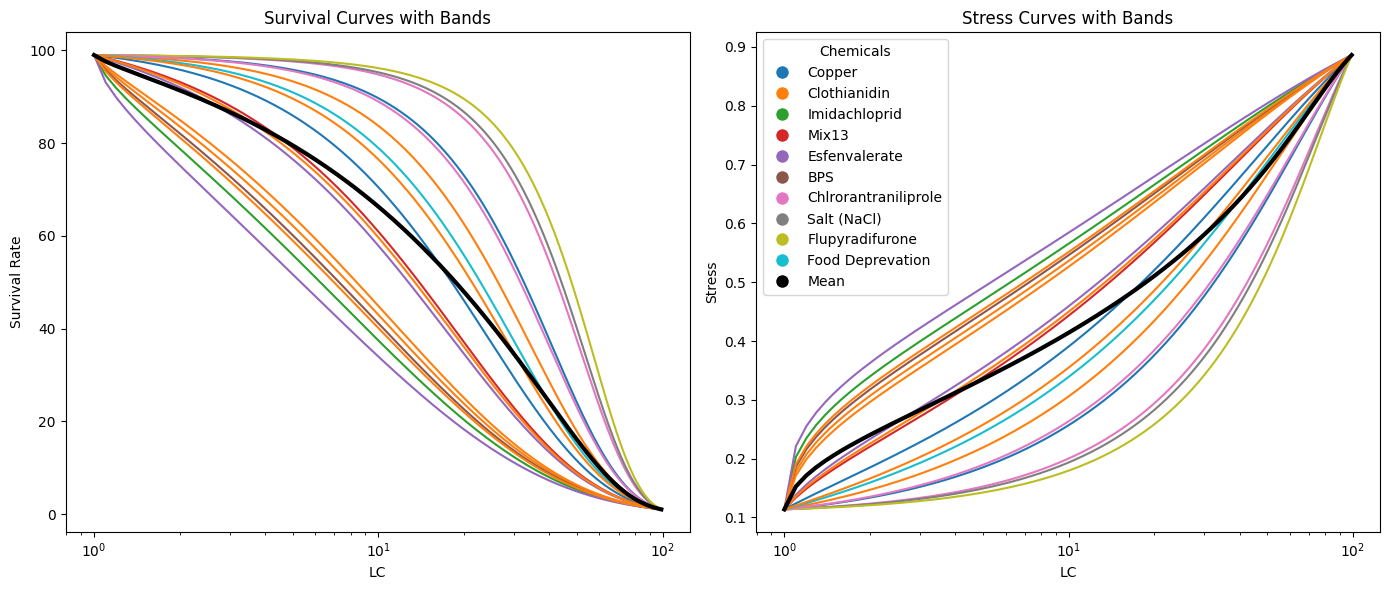

In [14]:
graphic("cleaned_curves", "cleaned_stress")

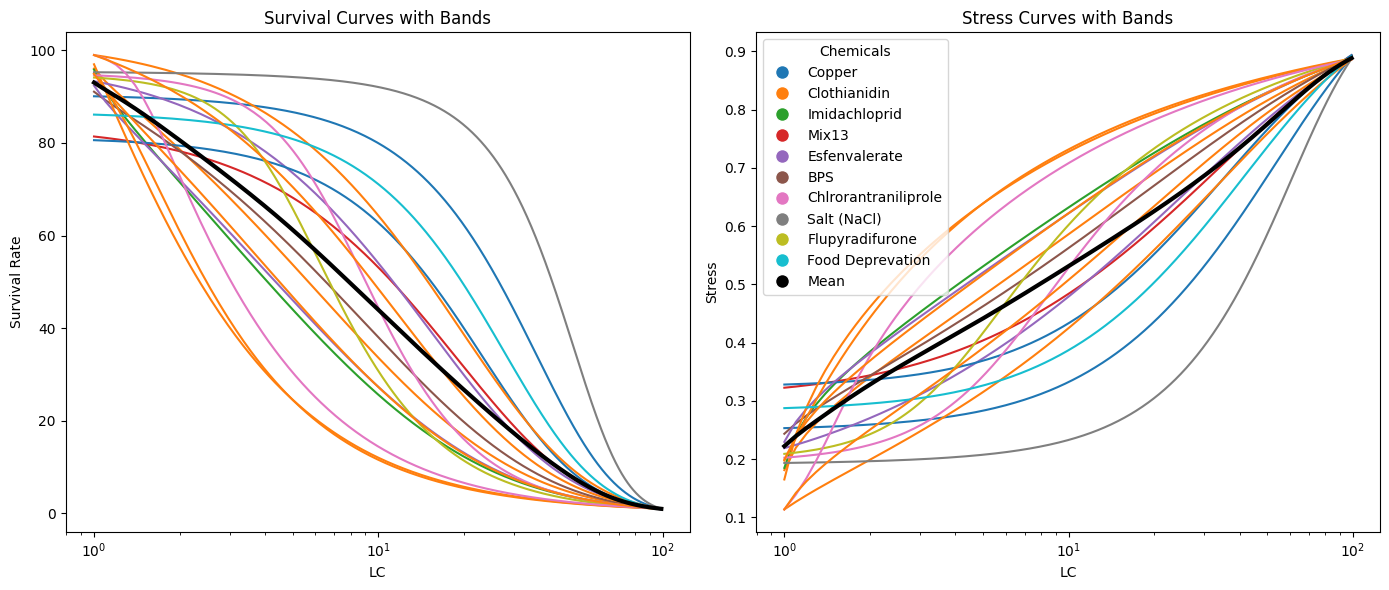

In [15]:
graphic("normed_curves", "stress")

In [34]:
def plot_graphic_text(df, with_mean = False):
    surv_col = "cleaned_curves"
    stres_col = "cleaned_stress"

    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    x = np.linspace(1, 99, 1000)
    for _, row in df.iterrows():
        
        axs[0].plot(x, row[surv_col], label = row.title)

    for _, row in df.iterrows():
        
        axs[1].plot(x, row[stres_col], label = row.title)
        
        
    if with_mean:
        
            mean_curve = np.mean(np.stack(df[surv_col].values), axis = 0)
            mean_stress = survival_to_stress(mean_curve / 100)

            axs[0].plot(x,mean_curve, label = "Mean", color = color_map["Mean"], linewidth = 3)
            axs[1].plot(x, mean_stress, label = "Mean", color = color_map["Mean"], linewidth = 3)

    axs[1].legend()
    axs[0].set_title('Survival Curves with Bands')
    axs[0].set_xlabel('LC')
    axs[0].set_ylabel('Survival Rate')
    axs[0].set_xscale("log")

    axs[1].set_title('Stress Curves with Bands')
    axs[1].set_xlabel('LC')
    axs[1].set_ylabel('Stress')
    axs[1].set_xscale("log")


    plt.tight_layout()
    plt.show()

In [35]:
mean_curve = np.mean(np.stack(df["cleaned_curves"].values), axis = 0)

ar = df.cleaned_curves.apply(lambda x : (x > mean_curve).mean()).sort_values().index.values

array(['huang_Flupyradifurone_2023', 'imrana_copper_2024',
       'ayesha_chlorantran_2022_reference',
       'ayesha_chlorantran_2022_agriculture', 'imrana_salt_2024',
       'naemm_Clothianidin_2024_reference'], dtype=object)

['huang_Flupyradifurone_2023', 'imrana_copper_2024', 'ayesha_chlorantran_2022_reference', 'ayesha_chlorantran_2022_agriculture', 'imrana_salt_2024', 'naemm_Clothianidin_2024_reference']


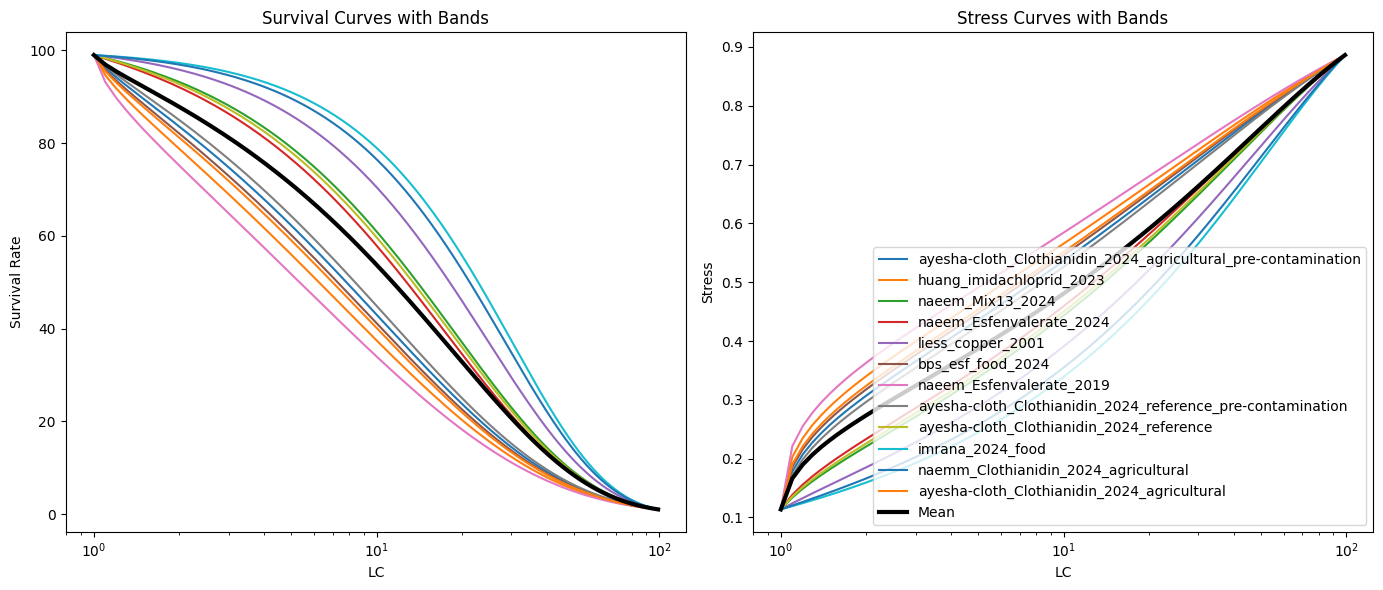

In [41]:
drop_index = ar[-6:]

print(df.iloc[drop_index].title.values.tolist())

used = df.drop(index = drop_index)
plot_graphic_text(used, with_mean=True)

mean_curve = np.mean(np.stack(used["cleaned_curves"].values), axis = 0)

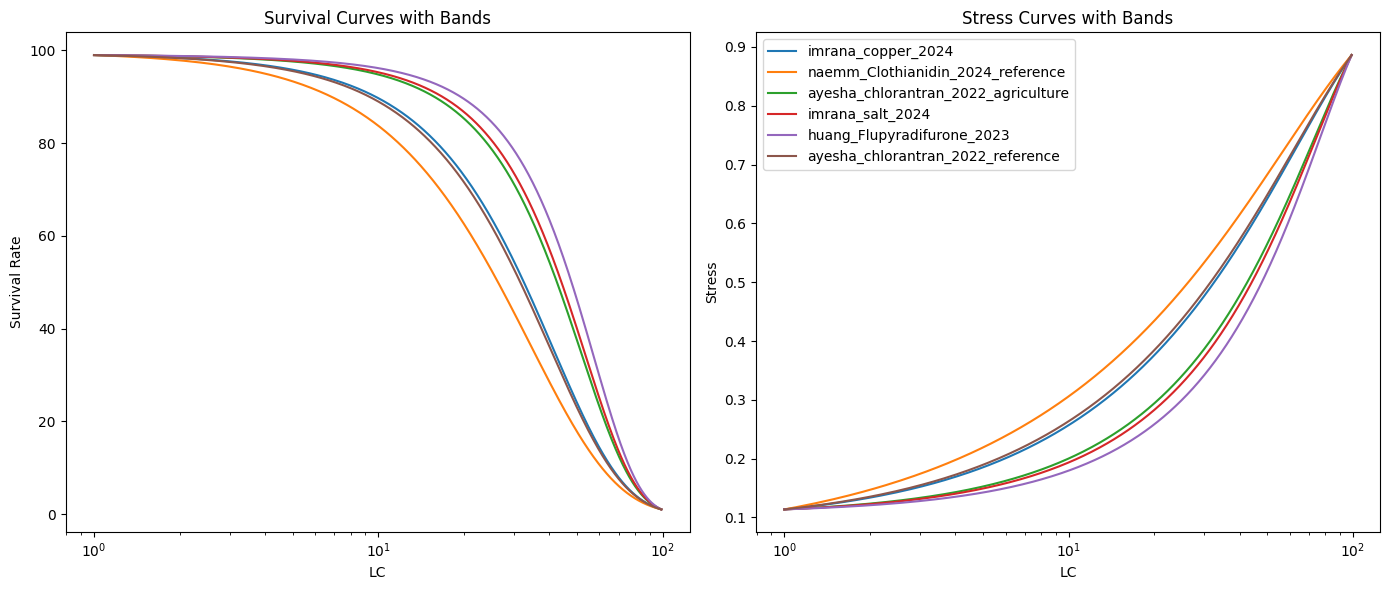

In [18]:
mean_curve = np.mean(np.stack(df["cleaned_curves"].values), axis = 0)

mask = df.cleaned_curves.apply(lambda x : (x > mean_curve).mean() > 0.5).values

bigger = df.iloc[mask]
plot_graphic_text(bigger)